In [1607]:
#%%
from collections import Counter
import pandas as pd 
import matplotlib as mt 
import sklearn as sk
import numpy as np 
import sklearn.metrics as metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy.stats as stats 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import norm
from sklearn.feature_selection import VarianceThreshold
import statsmodels.api as sm
from scipy.stats import pearsonr
import warnings
from warnings import simplefilter
warnings.filterwarnings('ignore')
from sklearn.exceptions import ConvergenceWarning
simplefilter(action="ignore", category=ConvergenceWarning)
warnings.simplefilter(action="ignore", category=UserWarning)




The dataset is taken from a Kaggle repository __[Company Bankruptcy Prediction](https://www.kaggle.com/datasets/fedesoriano/company-bankruptcy-prediction?datasetId=1111894&sortBy=dateRun&tab=profile)__

We shall segment the project into the following segments

* Data Cleaning and Standardizing 
* Initial EDA and Transformation 

* Explanatory Analysis 
    - Diagnostics 
    - Significant Coefficients 
* Predictive Modelling 
    - Cross Validation Preparation 
    - Parameter Optimization 
    - Confusion Matrix 
* Concluding Remarks 

The project is intended to provide both an explanatory view of factors that are strongly associated with higher likelihoods of bankruptcy amongst Taiwanese companies based on historical financial ratios - for potential business insights and also a predictive view with variables that contribute strongly for predictive model performance. 

# Data Cleaning and Standardization
 
We shall initialize the dataset and check for how the columns are currently formatted. 


In [1608]:
input_path = "/Users/ethan/Downloads/data 3.csv"
df = pd.read_csv(input_path)
print(df["Bankrupt?"])
bank_columns = list(df.columns)
print(bank_columns)

0       1
1       1
2       1
3       1
4       1
       ..
6814    0
6815    0
6816    0
6817    0
6818    0
Name: Bankrupt?, Length: 6819, dtype: int64
['Bankrupt?', ' ROA(C) before interest and depreciation before interest', ' ROA(A) before interest and % after tax', ' ROA(B) before interest and depreciation after tax', ' Operating Gross Margin', ' Realized Sales Gross Margin', ' Operating Profit Rate', ' Pre-tax net Interest Rate', ' After-tax net Interest Rate', ' Non-industry income and expenditure/revenue', ' Continuous interest rate (after tax)', ' Operating Expense Rate', ' Research and development expense rate', ' Cash flow rate', ' Interest-bearing debt interest rate', ' Tax rate (A)', ' Net Value Per Share (B)', ' Net Value Per Share (A)', ' Net Value Per Share (C)', ' Persistent EPS in the Last Four Seasons', ' Cash Flow Per Share', ' Revenue Per Share (Yuan ¥)', ' Operating Profit Per Share (Yuan ¥)', ' Per Share Net profit before tax (Yuan ¥)', ' Realized Sales Gross Pro

The presence of space and punctuations may cause dataframe indexing/slicing difficulties later in the project so we will standarize all columns by lowercasing and incorporating underscores between words. 

In [1609]:
def clean_col_names(col_name):
    col_name = (
        col_name.strip()
        .replace("?", "_")
        .replace("(", "_")
        .replace(")", "_")
        .replace(" ", "_")
        .replace("-", "_")
        .replace("__", "_")
        .replace("'", "")
        .lower()
    )
    return col_name
bank_columns = [clean_col_names(col_name) for col_name in bank_columns]
df.columns = bank_columns
print(df.columns)

Index(['bankrupt_', 'roa_c_before_interest_and_depreciation_before_interest',
       'roa_a_before_interest_and_%_after_tax',
       'roa_b_before_interest_and_depreciation_after_tax',
       'operating_gross_margin', 'realized_sales_gross_margin',
       'operating_profit_rate', 'pre_tax_net_interest_rate',
       'after_tax_net_interest_rate',
       'non_industry_income_and_expenditure/revenue',
       'continuous_interest_rate_after_tax_', 'operating_expense_rate',
       'research_and_development_expense_rate', 'cash_flow_rate',
       'interest_bearing_debt_interest_rate', 'tax_rate_a_',
       'net_value_per_share_b_', 'net_value_per_share_a_',
       'net_value_per_share_c_', 'persistent_eps_in_the_last_four_seasons',
       'cash_flow_per_share', 'revenue_per_share_yuan_¥_',
       'operating_profit_per_share_yuan_¥_',
       'per_share_net_profit_before_tax_yuan_¥_',
       'realized_sales_gross_profit_growth_rate',
       'operating_profit_growth_rate', 'after_tax_net_profit

We shall check for the level of imbalance between the binary classes for the bankruptcy_ column, which indicates a 1/0 class depending on if the company has declared bankruptcy or not.

We see that there is a great disparity in the frequency of non-bankrupt and bankrupt companies. This will be important to note later in the project, as appropriate accuracy scores that address this imbalanced must be used to tune the parameters of the predictive model.

In [1610]:

df.info()
df['bankrupt_'].value_counts()
df.astype('float64')
df = df.dropna()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   bankrupt_                                               6819 non-null   int64  
 1   roa_c_before_interest_and_depreciation_before_interest  6819 non-null   float64
 2   roa_a_before_interest_and_%_after_tax                   6819 non-null   float64
 3   roa_b_before_interest_and_depreciation_after_tax        6819 non-null   float64
 4   operating_gross_margin                                  6819 non-null   float64
 5   realized_sales_gross_margin                             6819 non-null   float64
 6   operating_profit_rate                                   6819 non-null   float64
 7   pre_tax_net_interest_rate                               6819 non-null   float64
 8   after_tax_net_interest_rate           

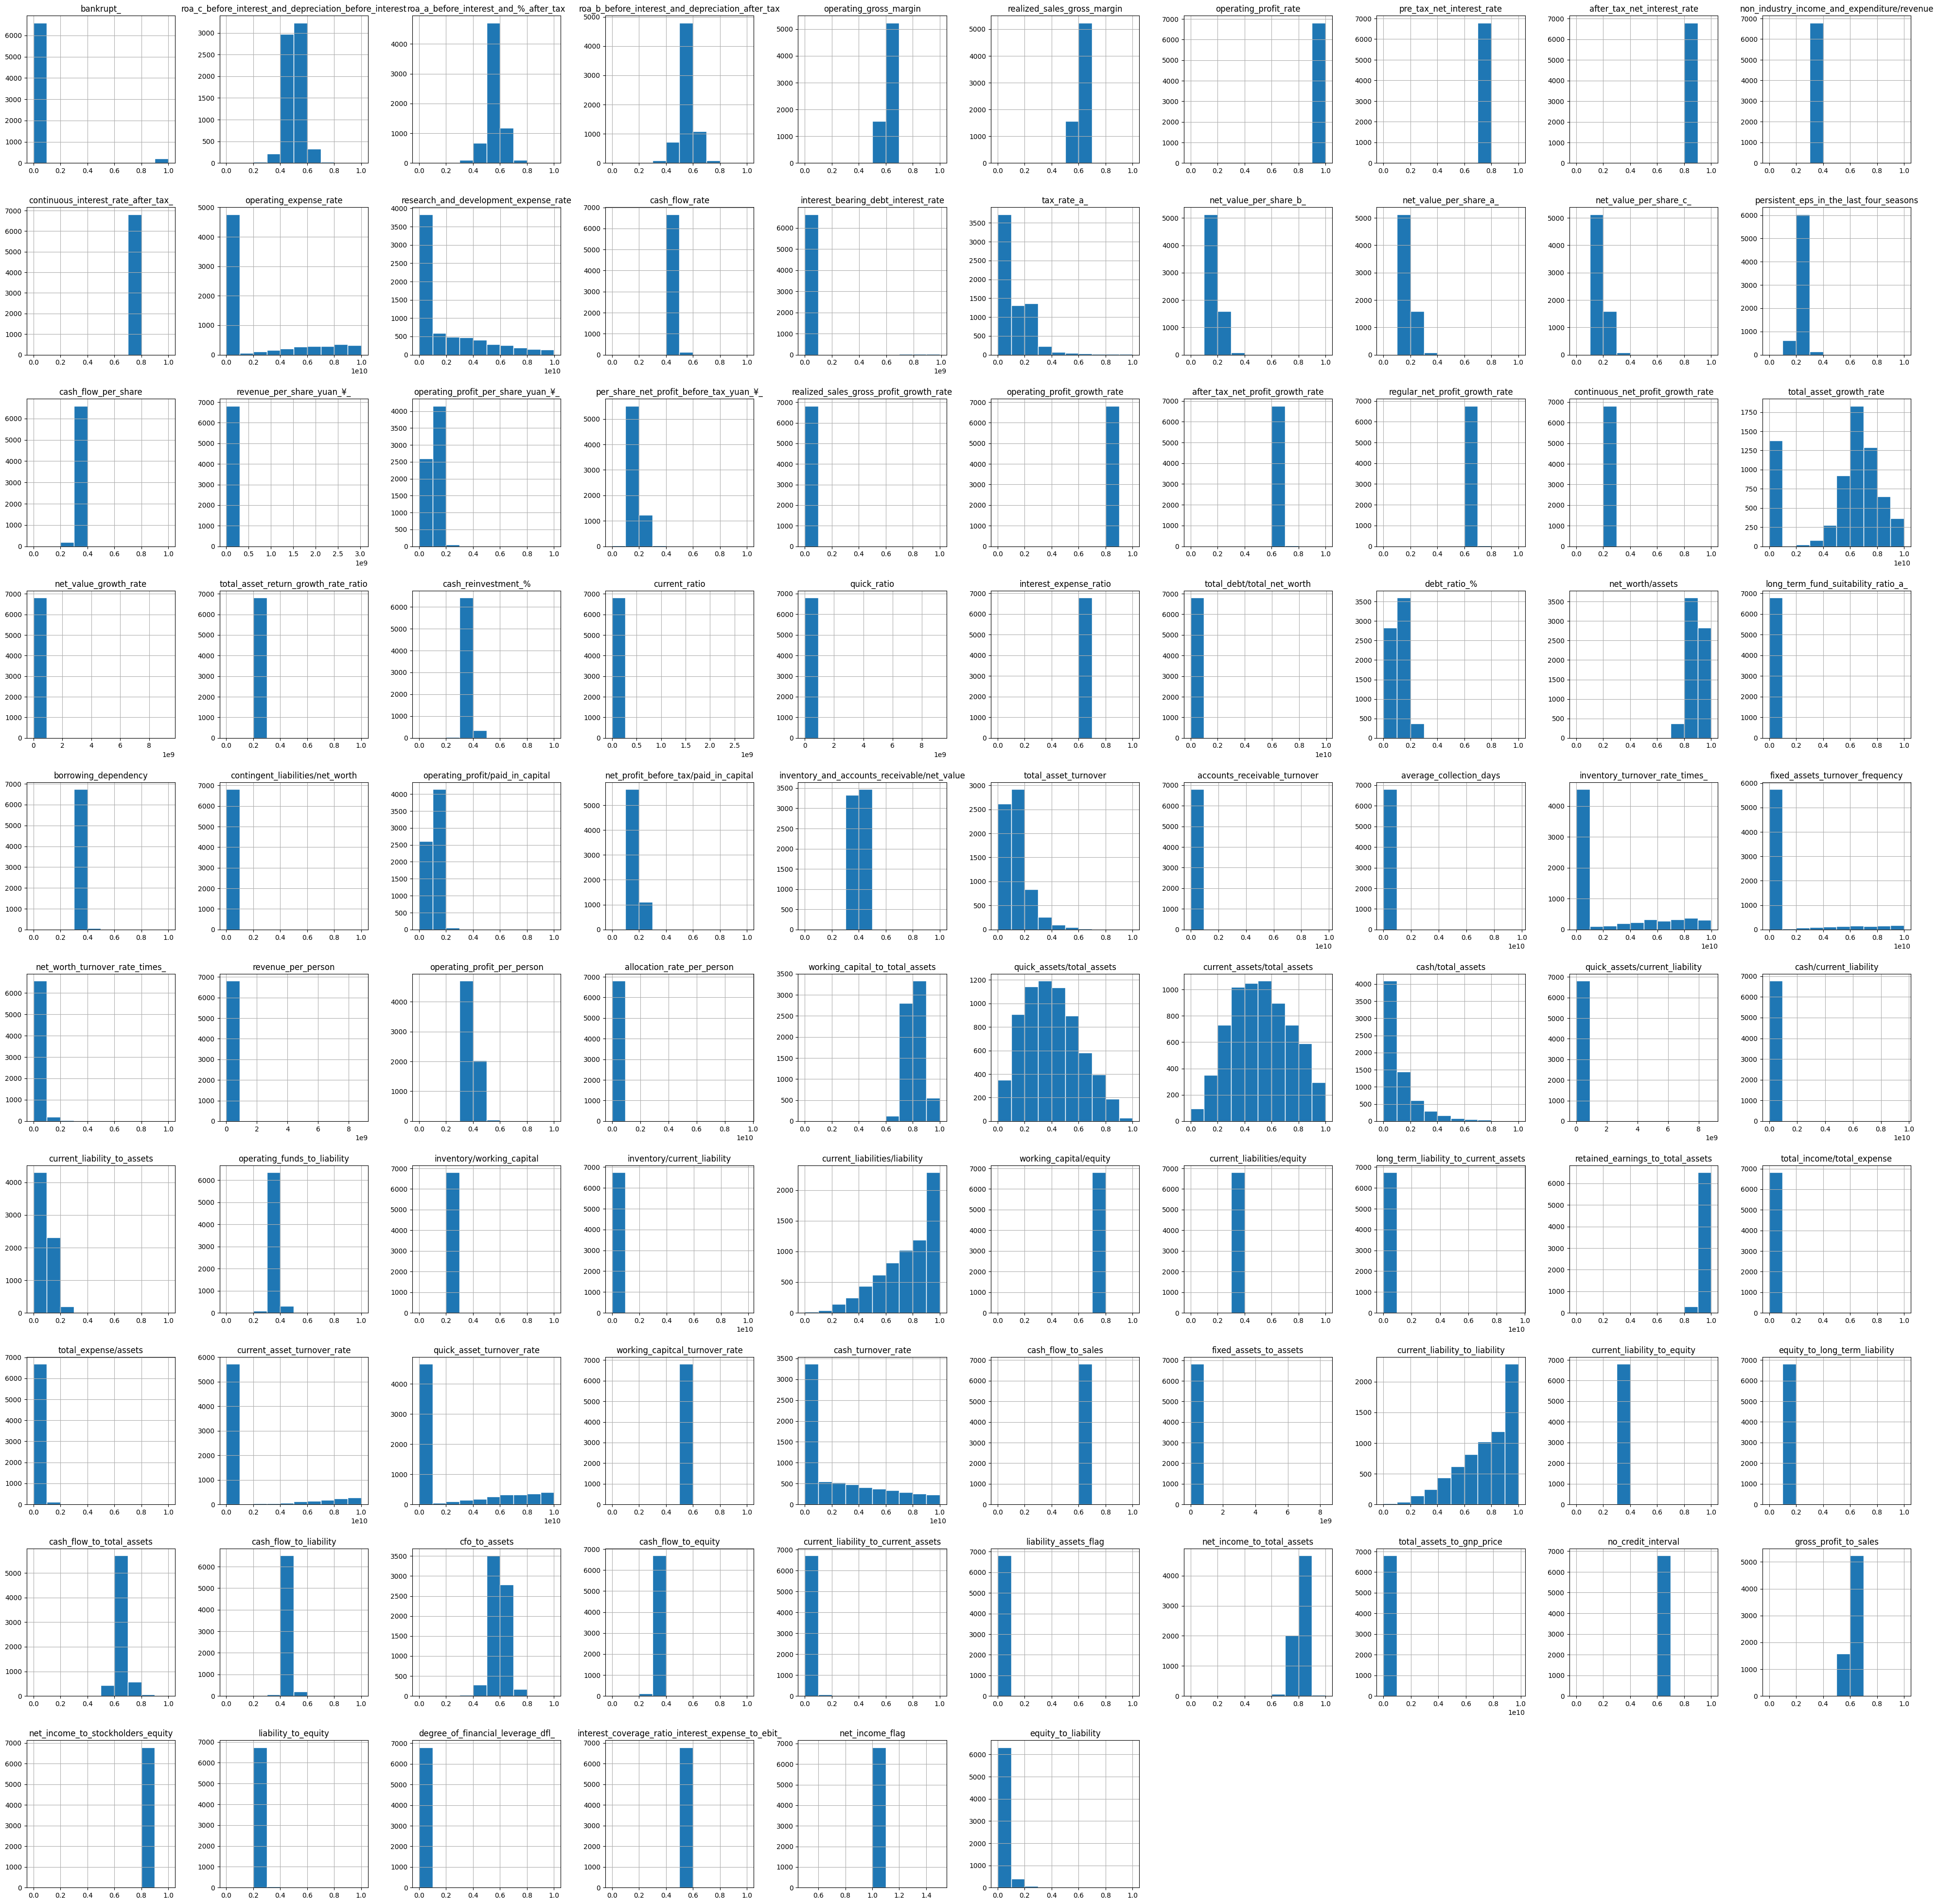

In [1611]:
df.hist(figsize=(50,50), edgecolor = 'white')
plt.show()

Based on the varied scales of individual column values across the records, we see that standardization of variables are necessary for explanatory analysis before we build the regression model.

In [1612]:
scaler = preprocessing.MinMaxScaler(feature_range = (0,1))
df2 = df.drop(['bankrupt_'], axis=1)
df_scaled = scaler.fit_transform(df2)
df2 = pd.DataFrame(df_scaled, columns= df2.columns)

# Initial EDA and Transformation

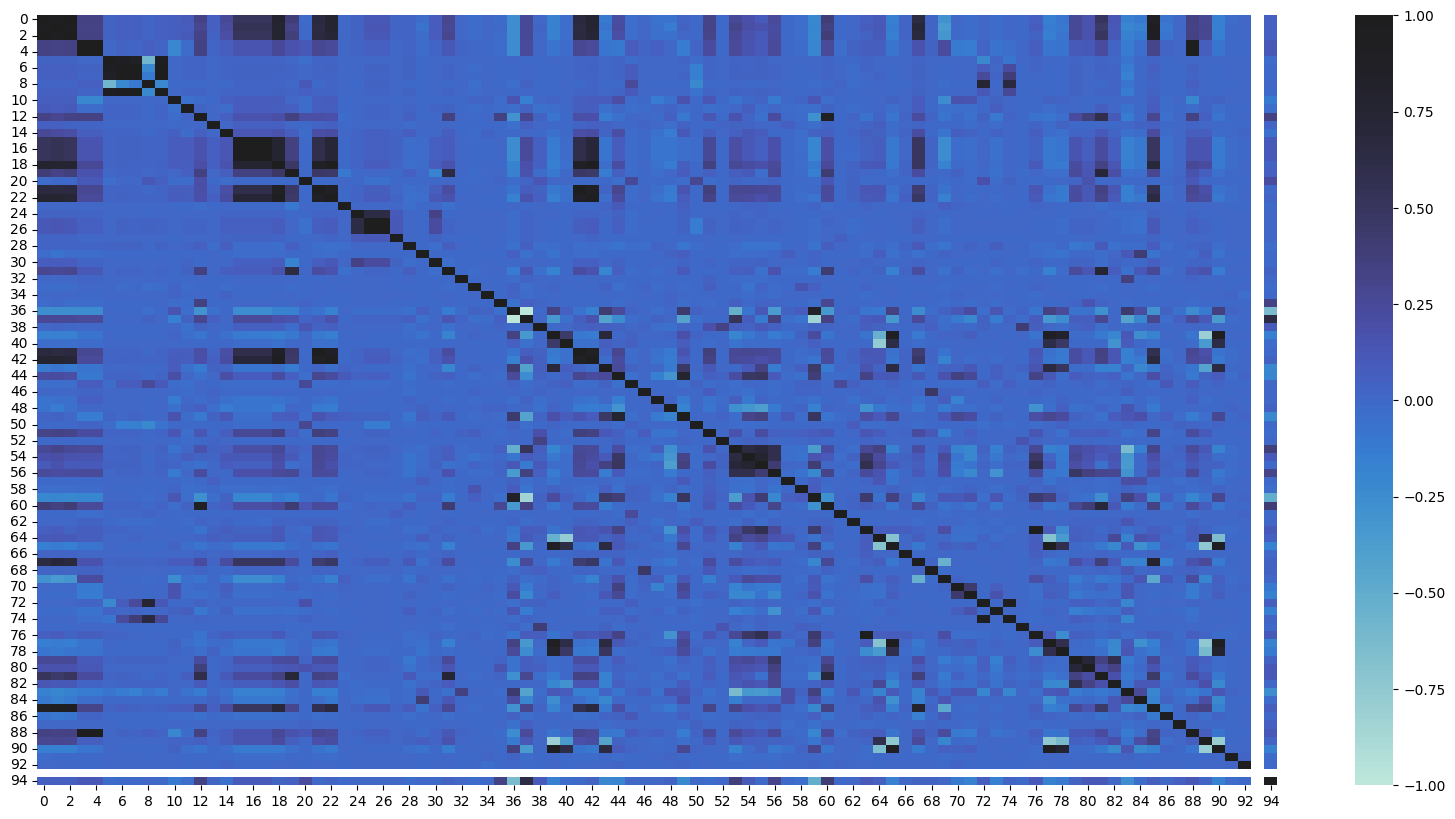

In [1613]:
corr_mat = np.corrcoef(df2,rowvar=False)
corr_mat = pd.DataFrame(corr_mat)
corr_mat.style.background_gradient(sb.light_palette('blue', as_cmap=True))
corr_heat = sb.heatmap(corr_mat, vmin=-1, vmax=1, center=True, annot=False)
plt.rcParams['figure.figsize'] = [40, 40]
plt.show()

We see that there is a high degree of correlation (> 0.6) between several variables in the dataset. This will pose the problem of multicollinearity when extracting insights via Logistic Regression. 

Multicollinearity is when the coefficient estimates of the regression model are unreliable for interpretation, as a result of high correlation between explanatory variables. One of the assumptions of logistic regression models, are that the features independent of each other. Thi is because the logistic regression intends to estimate the effect of one variable, holding other variables constant. 

We will also remove low variance values, as we see that there are a large fraction of columns with highly concentrated histograms which indicate extremely low variance. These variables do not contribute greatly to the fitting of the model, nor can we extract meaningful linear trends from them as a result of this low variance and the small magnitude of the effect size. 

In [1614]:
Y=df["bankrupt_"]
X=df2
Variance_Threshold = VarianceThreshold(threshold=0.001)
Variance_Threshold.fit(X)
concol = [column for column in X.columns
          if column not in X.columns[Variance_Threshold.get_support()]]
X = X.drop(concol,axis=1)
X = pd.DataFrame(X)
X.info('')
def calculate_vif_(X, thresh=5):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 40 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   roa_c_before_interest_and_depreciation_before_interest  6819 non-null   float64
 1   roa_a_before_interest_and_%_after_tax                   6819 non-null   float64
 2   roa_b_before_interest_and_depreciation_after_tax        6819 non-null   float64
 3   operating_expense_rate                                  6819 non-null   float64
 4   research_and_development_expense_rate                   6819 non-null   float64
 5   interest_bearing_debt_interest_rate                     6819 non-null   float64
 6   tax_rate_a_                                             6819 non-null   float64
 7   net_value_per_share_b_                                  6819 non-null   float64
 8   net_value_per_share_a_                

The Variance Inflation Factor (VIF) is a useful formula for detecting how much of a factor the variance of a regression coefficient is inflated due to its high correlation with other coefficients. 

This function iteratively shall calculate the Variance Inflation Factors (VIF) of each of the independent variables, and take out variable that exceed a specified cutoff score with the highest margin within each iteration. This will be conducted until we reach the final iteration, which is deemed to be when none of the remaining variables have a VIF that exceeds the cutoff score.  

A general rule of thumb is that if the VIF score is greater than 4 or 5 indicates a high level of correlation between the explanatory variable and other variables, enough to deem the estimates of its coefficient to be unreliable due to high variance. 

dropping 'debt_ratio_%' at index: 13
dropping 'current_liabilities/liability' at index: 27
dropping 'net_value_per_share_a_' at index: 8
dropping 'net_value_per_share_b_' at index: 7
dropping 'working_capital_to_total_assets' at index: 17
dropping 'roa_b_before_interest_and_depreciation_after_tax' at index: 2
dropping 'net_income_to_total_assets' at index: 31
dropping 'roa_c_before_interest_and_depreciation_before_interest' at index: 0
dropping 'persistent_eps_in_the_last_four_seasons' at index: 6
dropping 'net_worth/assets' at index: 8
dropping 'cfo_to_assets' at index: 26
dropping 'roa_a_before_interest_and_%_after_tax' at index: 0
dropping 'cash_flow_to_total_assets' at index: 24
dropping 'operating_profit_per_person' at index: 11
dropping 'per_share_net_profit_before_tax_yuan_¥_' at index: 5
dropping 'operating_funds_to_liability' at index: 15
dropping 'current_liability_to_liability' at index: 20
dropping 'current_assets/total_assets' at index: 11
dropping 'net_value_per_share_c_'

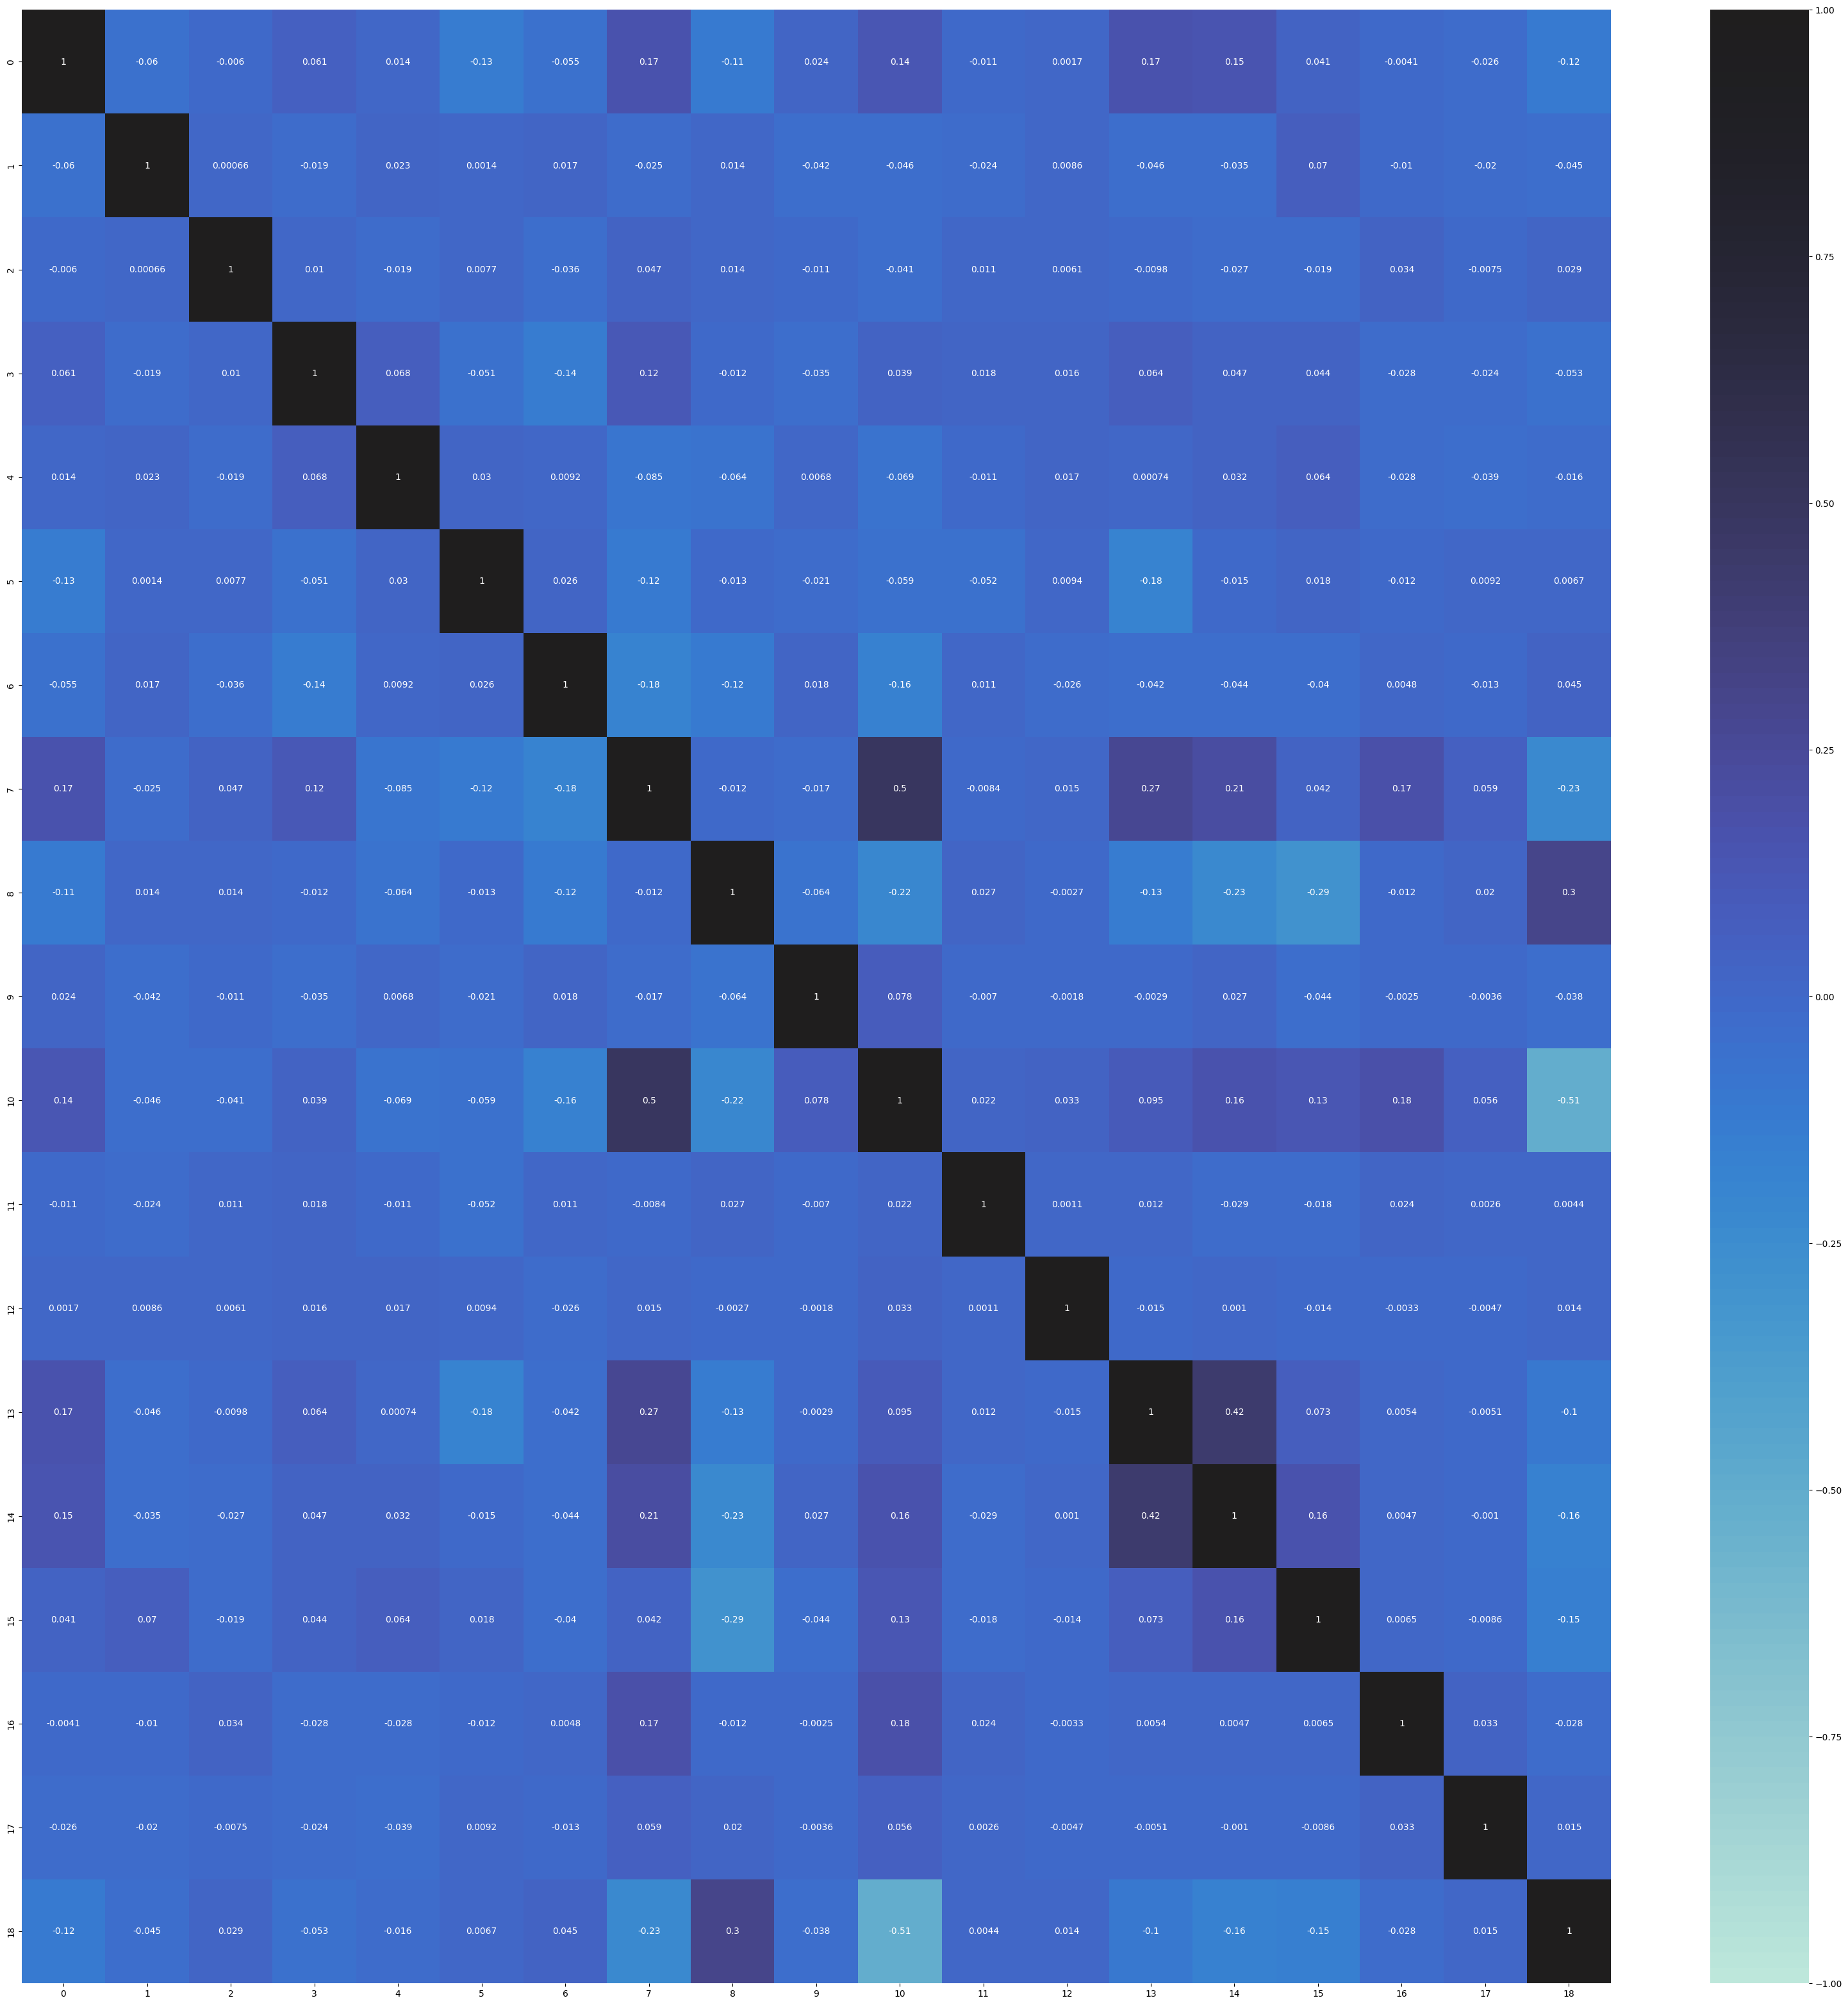

AxesSubplot(0.125,0.11;0.62x0.77)


In [1615]:
X=X.pipe(calculate_vif_)
X.info()
corr_mat_1 = np.corrcoef(X,rowvar=False)
corr_mat_1 = pd.DataFrame(corr_mat_1)
corr_mat_1.style.background_gradient(sb.light_palette('blue', as_cmap=True))
corr_heat_1 = sb.heatmap(corr_mat_1, vmin=-1, vmax=1, center=True, annot=True)
plt.rcParams['figure.figsize'] = [20, 10]
plt.show()
print(corr_heat)

We see that the relative correlation of the remaining 18 variables are all within a reasonable range (< 0.6), and do not possess a high enough VIF to cause unreliable coefficient estimates. 

# Explanatory Analysis

We shall build a logistic regression model based on historical data, to provide an explanatory analysis of how the remaining variables when isolated, are correlated with a higher likelihood of bankruptcy. 

A logistic regression model follows the linear equation : logit(P) = a + bX 

Where P is the probability of the positive class (1) occuring,  the logit function derives the log - odds of P. 

The log - odds of P is derived as : ln(P/(1-P)).

This logit link function is what linearizes the probability of the positive class, with the coefficients (b) of our variables (X). 

This is important for the interpretation of our coefficient estimates: such that a 1 unit increase in the variable X holding other variables constant, is correlated with a b log odds of a company declaring bankruptcy. 

The log odds (b) is associated with the probability through this formula: p = exp(b)/(1+exp(b))

In [1616]:
X_exog = sm.add_constant(X)
log_r_stats = sm.Logit(Y, X_exog).fit()

Optimization terminated successfully.
         Current function value: 0.108605
         Iterations 10


### Diagnostics 

The assumptions of the binary logistic regression model are the following : 

  - The variables show no significant multicollinearity 
  - The relationship of the log-odds of the positive class and each of the independent variables is linear 
  - The outcome class is binary (1/0)

The VIF function utilized had been successful as a form of both feature selection, and also addressing the issue of multicollinearity. As shown earlier, none of the correlations of the remaining variables exceed 0.5 with the highest seen correlation coefficient between 2 variables being 0.5 and no variable with a VIF of more than 5. 

The binary outcome that we are testing for, is bankrupt/non-bankrupt. 

This leaves us with the assumption of linearity between the log-odds of the outcome, and each indepenent variable for us to test. We shall linearly regress the variables individually against the binary class that is linked through a logit function of its odds, and plot the log odds against each respective variable based on its regression to check for its linear effect on the log-odds. 

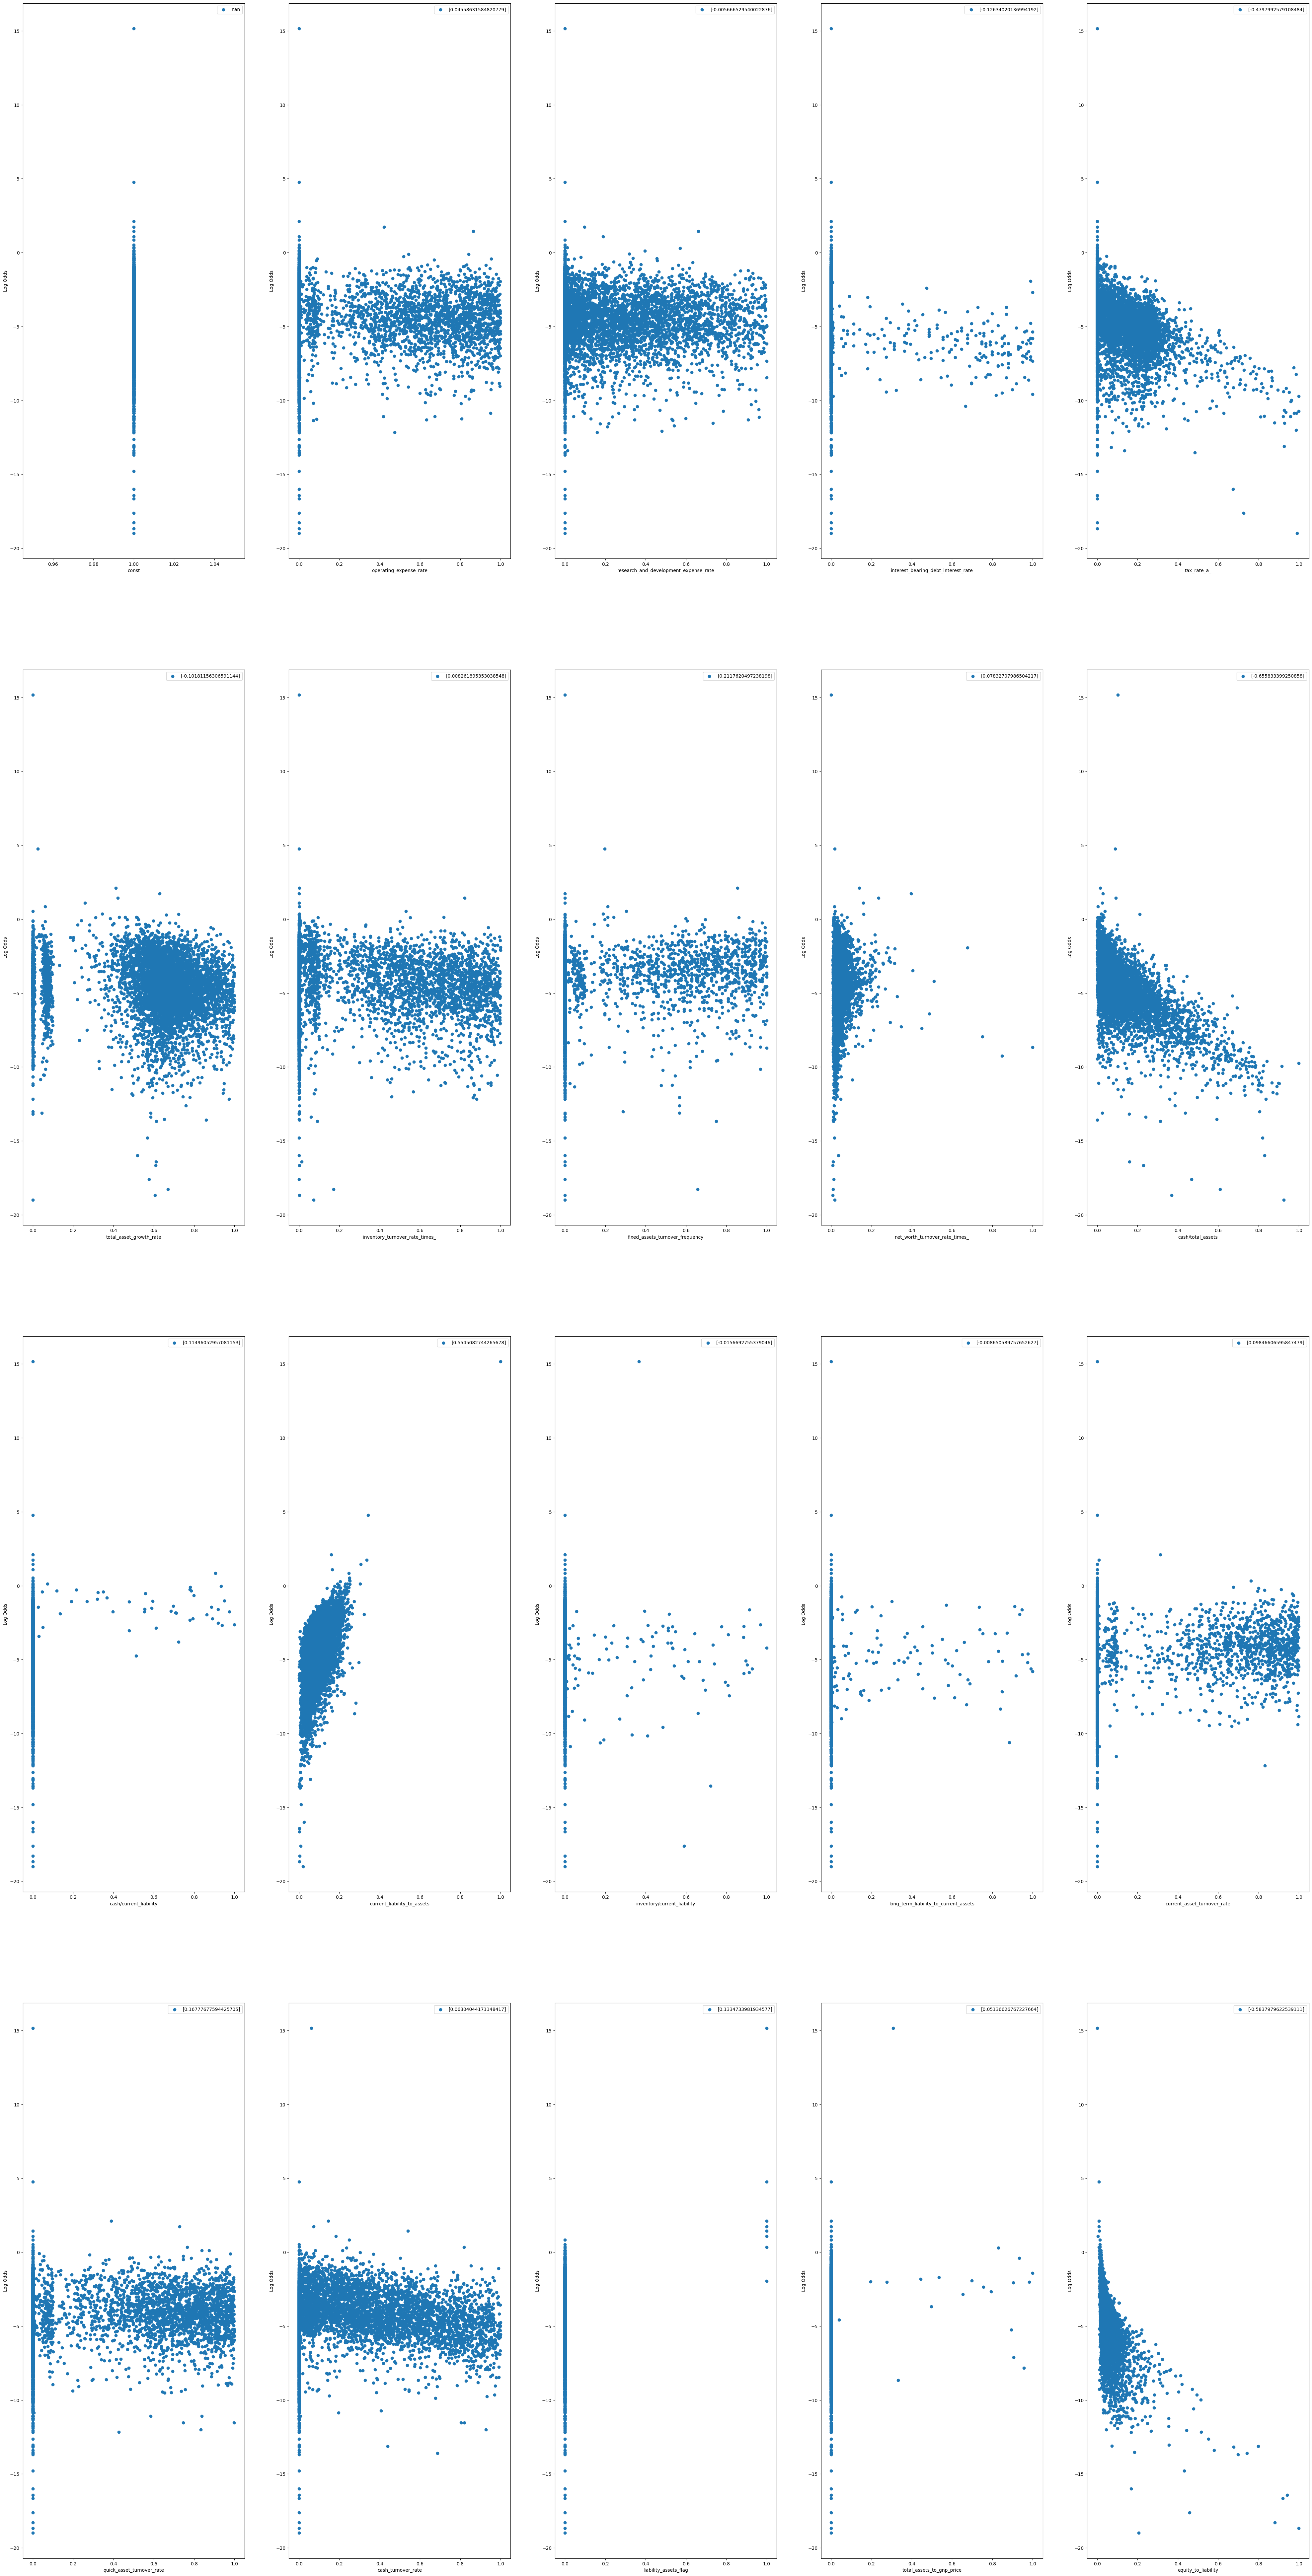

In [1617]:
resi_prob = [ ]
predictor_variable = [ ]
resi_prob.append(log_r_stats.predict(X_exog))
resi_prob = pd.DataFrame(resi_prob)
resi_prob = np.log(resi_prob / (1 - resi_prob))
resi_prob = pd.DataFrame(resi_prob)
resi_prob = resi_prob.transpose()
fig, ax = plt.subplots(4,5, figsize=(50, 100))
for i in range(0,5):  
    corr, _ = pearsonr(X_exog.iloc[:,i], resi_prob)
    ax[0,i].scatter(x = X_exog.iloc[:,i], y = resi_prob, label =f'{corr}' )
    ax[0,i].set_xlabel(f"{X_exog.columns[i]}")
    ax[0,i].set_ylabel("Log Odds")
    ax[0,i].legend(loc="upper right")
for i in range(0,5):  
    corr, _ = pearsonr(X_exog.iloc[:,i+5], resi_prob)
    ax[1,i].scatter(x = X_exog.iloc[:,i+5], y = resi_prob, label =f'{corr}')
    ax[1,i].set_xlabel(f"{X_exog.columns[i+5]}")
    ax[1,i].set_ylabel("Log Odds")
    ax[1,i].legend(loc="upper right")
for i in range(0,5):  
    corr, _ = pearsonr(X_exog.iloc[:,i+10], resi_prob)
    ax[2,i].scatter(x = X_exog.iloc[:,(i+10)], y = resi_prob, label =f'{corr}')
    ax[2,i].set_xlabel(f"{X_exog.columns[i+10]}")
    ax[2,i].set_ylabel("Log Odds")
    ax[2,i].legend(loc="upper right")
for i in range(0,5):  
    corr, _ = pearsonr(X_exog.iloc[:,i+15], resi_prob)
    ax[3,i].scatter(x = X_exog.iloc[:,(i+15)], y = resi_prob, label =f'{corr}')
    ax[3,i].set_xlabel(f"{X_exog.columns[i+15]}")
    ax[3,i].set_ylabel("Log Odds")
    ax[3,i].legend(loc="upper right")
plt.show()

Due to the abundance of 0 values in each of the explanatory variables, we see that there is a cluster of these values distributed across the y axis. This will serve to deflate the correlation coefficient. Possible reasons to attribute for this is reporting error, and the timing at which the financial information on a company was reported. 

We can see that a portion of the variables have a correlation coefficient with the log-odds of bankruptcy of less than 0.1. This trend is seen most in variable's scatterplots resemble that of a near horizontal line. This indicates that there is a very weak linear relationship between these variables and the log-odds of the outcome.  

This is reflected in the statistical significance of the coefficient estimates of such variables, as of the 9 variables with a correlation coefficient shown above less than (0.1).  8 of the aforementioned are statistically insignificant on the 90% confidence interval, thus we cannot say with a reasonabe level of confidence that their coefficient estimates differ from 0.

#### Addressing Limitations

We can interpret the trend between the variables and log-odds with zero-inflated scatterplots, as there being a 0 threshold that the variable passes before having linearity between the log-odds. Thus there could possibly only be a linear relationsip between non-zero values or variables and the log-odds of bankruptcy. 

Despite the lack of strength in linearity among some of the variables, it can be perceived that adding polynomial terms which serve to fit non-linear relationships will also not provide a good fit for the variables as most of these relationships can be interpreted as close to random noise across the standardized values on the x-axis. 

We can conclude from the variable's coefficient estimates of the logistic regression, as not having enough precision for us to disprove that it differs from 0. 

Our analysis has been centered around statistically significant coefficients, where higher regression coefficients are reflected in generally higher correlation coefficients in the scatterplot as shown from the variables - Tax Rate, Cash/Total Assets, Current Liability to Assets and Equity to Liability with a correlation coefficient of > 0.45. Reconciling this limitation with our earlier explanatory analysis, we must recognize that there is a risk of the coefficients of the statistically significant variables being deflated/inflated due to weak linearity. 

We are able to uphold the linear trend of the 4 coefficients due to the visible linearity shown in their scatterplots including the liability assets flag which is a categorical variable, this helps to validate our insights later on the variable's regression coefficients of these variables in terms of their positive/negative linear relationship on the likelihood of bankruptcy regardless if the coefficient effect size is warped by zero values.

In [1618]:
print(log_r_stats.summary())

                           Logit Regression Results                           
Dep. Variable:              bankrupt_   No. Observations:                 6819
Model:                          Logit   Df Residuals:                     6799
Method:                           MLE   Df Model:                           19
Date:                Fri, 18 Nov 2022   Pseudo R-squ.:                  0.2380
Time:                        03:08:39   Log-Likelihood:                -740.58
converged:                       True   LL-Null:                       -971.86
Covariance Type:            nonrobust   LLR p-value:                 3.905e-86
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -3.0375      0.477     -6.372      0.000      -3.972      -2.103
operating_expense_rate                   -0.2857  

### Significant Coefficients 

For this project we shall take a closer look into coefficients with that are statistically siginificant on the 90% Confidence Interval, which denotes that the P-Value of the respective explanatory variables is < 0.10 while also supporting the assumption of linearity as discussed in the previous section.

An interesting insight is that the coefficients can be segmented into the respective categories based on what the financial metric is being intended to measure : Liquidity, Leverage/Balance Sheet Health and Profitability

Liquidity is associated with how well a company is able to use its current short-term assets to pay off its current short-term liabilities. A company that is able to meet its short-term debt obligations by a healthy margin is known to be of favorable liquidity, and thus less likely to declare bankruptcy. The variables that measure liquidity that are statistically significant estimators of the odds of bankruptcy - Cash/Total Assets. This linear trend validates our initial hypothesis that greater liquidity is correlated with lower probability of bankruptcy, as the level of liquidity relative to total assets has a strong negative relationship (b =-7.3849) with the probability of bankruptcy. 

The leverage shows the proportion of debt the company has to the total sum of its equity and debt. Strong signs point towards higher leverage being associated with higher probability of bankruptcy shown from the positive coefficient in the liability assets flag, which indicate if liability exceeds assets which strongly implies solvency issues. This is mainly due to the fact that this reflects deficient equity which could be causes by recurring negative cash flows and losses. (b = - 3.2595) Equity to liabilites ratio also show a steep negative correlation with bankruptcy (b = -12.5321), which serves to say that leverage is the most significant linear trend with the probability of bankruptcy. This trend is further substantiated by the strong positive relationship between the variable current liabilities to assets and bankruptcy. (b = 15.2983), indicating that larger proportions of short term debt is representative of financial distress.

Lastly, we have the effective tax rate which has a strong negative relationship with the odds of bankruptcy. The effective tax rate is the percent of total earned income that is owed in taxes. A broad inference we can make, is that a higher tax rate typically implies higher taxable income thus this coefficient acts as a proxy for overall profitability of a company. (b = -6.7724 )

The current liabilities to assets and liability to assets flag provide us a rudimentary view of the level of financial distress. The effective tax rate, cash/total assets and equitiy to liabilties ratio runs in tandem with this rationale while serving as a reflection of how successfully a Taiwanese company would be able to deter the event of bankruptcy. The portion of the balance sheet allocated towards cash, the level of leverage taken on, and the general profitability of the company from an absolute standpoint all display clear linear trends against the log-odds of bankruptcy when holding all other variables/views of a company's financial health constant. 

We see that the p-value of the log-likelihood, which indicates the goodness of fit of the model is within the 95% confidence interval. The p-value tells us that we can conclude with reasonable confidence that this model provides a better fit than a null model which provides backing to our results.

# Predictive Modelling 

Even though we see weak linear trends across most of the coefficients in our model which has resulted in statistical insignificance and a lack of explanantory power, we are able to put less emphasis on statistical significance and insights when it comes to building a predictive model aimed at high accuracy.

### Cross Validation Preparation 

We shall split the dataset into a 80/20 split for training and testing data. 

In [1619]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42, stratify=Y, shuffle=True)

### Parameter Optimization 

The bulk of the work will come from tuning of the hyper-parameters and parameter selection, which we will be able to automate by making multiple iterations of the model with varying parameters. We must also utilize discretion in the scoring metric that this predictive model will optimize for. As we have seen earlier, the dataset is largely imbalanced with a disproportionate ratio of non-bankrupt companies to bankrupt companies. An imbalanced dataset does not pose problems during explanatory analysis as we seeked to simply tell a story based on historical data. Rebalancing the dataset through either cutting back on the number of non-bankrupt companies in our dataframe or interpolating new artificial records (SMOTE) will introduce further bias in the results of our explanatory model due to it not being representative of the class distribution in reality. The ratio between binary classes is also not so much an issue in this case if there is a reasonable number of records in the positive (1) class which we have. 

Framing this issue from the lens of building predictive models, a model trained on artificial records in the test set will not yield significantly higher accuracy scores as compared to imbalanced training data. We will instead utilize class weights and optimizing for the F1 score. Class weights penalizes mistakes by either of the binary classes with a multiplier, mainly to put more emphasis on the lack of positive classes in datasets without needing to create artificial records. The F1 score is the harmonic mean of a model's precision and recall values, while the F1 macro score is the unweighted mean of the F1 score for both classes.

Accuracy scores on imbalanced data will not be representative of the model's ability to detect positive classes due to the disproportion. The use of the accuracy score fails to take into account the effect of false negatives due to the low number of positive classes as we are able to still yield an above 90% accuracy even when labelling all records that are positive classes as negative. The F1 macro score will be a substitute for accuracy in this imbalanced data as it takes into account both the model's rate of false positives and false negatives for each class.

The penalty terms specify how we would want to regularize our logistic regression to prevent overfitting, by deflating coefficient magnitudes. C stands for the learning rate of each iteration which help to regularize the model with smaller values. Solver is the cost function that we specify to minimize. We will use the highest scoring parameters for the model based on cross validation which is derived from optimal hyper-parameters, fit this model onto the complete training data. 

In [1620]:

log_r = LogisticRegression(class_weight='balanced')
log_r.fit(X_train,Y_train)
parameters = {"penalty": ['l1','l2', 'elasticnet'],
                  'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                  'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
randm_src = RandomizedSearchCV(estimator=log_r, param_distributions = parameters, n_iter =1000, n_jobs=-1,cv=5,scoring="f1_macro")
randm_src=randm_src.fit(X_train,Y_train)
print(randm_src.best_params_)
log_r = randm_src.best_estimator_
y_train_pred = log_r.predict_proba(X_train)
y_train_pred_prob_lowerThres = y_train_pred[:,1] > 0.5
arg_train = {'y_true':Y_train, 'y_pred':y_train_pred_prob_lowerThres}
print(confusion_matrix(**arg_train))
print(classification_report(**arg_train))

/Users/ethan/Documents/ethan/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ethan/Documents/ethan/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ethan/Documents/ethan/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ethan/Documents/ethan/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ethan/Documents/ethan/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ethan/Documents/ethan/lib/py

{'solver': 'sag', 'penalty': 'l2', 'C': 1000}
[[4896  383]
 [  85   91]]
              precision    recall  f1-score   support

           0       0.98      0.93      0.95      5279
           1       0.19      0.52      0.28       176

    accuracy                           0.91      5455
   macro avg       0.59      0.72      0.62      5455
weighted avg       0.96      0.91      0.93      5455



We see that our training score yields a F1 Macro score of around 60% with the optimized parameters. We shall now apply this model onto the test set. 

In [1621]:
y_test_pred = log_r.predict_proba(X_test)
y_test_pred_prob_lowerThres = y_test_pred[:,1] > 0.5
arg_test = {'y_true':Y_test, 'y_pred':y_test_pred_prob_lowerThres}
print(confusion_matrix(**arg_test))
print(classification_report(**arg_test))

[[1223   97]
 [  24   20]]
              precision    recall  f1-score   support

           0       0.98      0.93      0.95      1320
           1       0.17      0.45      0.25        44

    accuracy                           0.91      1364
   macro avg       0.58      0.69      0.60      1364
weighted avg       0.95      0.91      0.93      1364



### Confusion Matrix 

We see that our model also yields a F1 macro score of around 60%. This is a more transparent indicator of model performance, taking into account the precision and accuracy rate of the model in predicting for each class. Due to the non-linearity and lack of correlation between the log-odds and many of the predictor variables we can find better suited algorithms such as Random Forest and Naive Bayes, which will be beyond the scope of this project. 

# Conclusion 

It is an important initial step to distinguish the functions of regression models that assume linearity between explanatory analysis, and prediction. 

Explanatory Analysis requires the validation of assumptions, along with proper interpretation of coefficient estimates depending on whether the endogenous variable is connected to the specific outcome variable with a link function. Statistical significance allows us to rationalize with a reasonable degree of confidence that there is a linear trend in the total population of Taiwanese companies to some degree between the liquidity, leverage and profitability metrics and the log-odds of bankruptcy based on historical data. 

Predictive power draws less attention to coefficient significance and gaining insights backed by assumptions and more so into performance metrics. The use of the F1 macro score and class weights is able to sufficiently address the issue of class imbalance.

This project was intended to show the utilities that regression models have to offer in both respects. The logistic regression model has been weak in capturing non-linear relationships, if any, between the log-odds and the predictor variables possible ways this could be remedied is through polynomial terms and splines. The use of more nuanced algorithms such as Random Forest or Naive Bayes, or addition of polynomial terms throughj General Additive Terms for better fit could also be yield more favorable results in predictive use. There is explanatory merit in logistic regression when used to detect linear trends, and selecting optimal parameters based on suitable scoring metrics provide a reasonable degree of predictive ability. 